# Learn PyTorch Step-by-Step: A Beginner's Guide

# Chapter 2

In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

In [3]:
import os
import errno
import requests

folders = ['data_generation', 'data_preparation', 'model_configuration', 'model_training']
filenames = ['simple_linear_regression.py', 'v0.py', 'v0.py', 'v0.py']

base_url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/'

for folder, filename in zip(folders, filenames):
    try:
        os.mkdir(folder)
    except OSError as e:
        e.errno
        if e.errno != errno.EEXIST:
            raise
            
    if os.path.exists('/colabtools'):
        path = os.path.join(folder, filename)
        url = '{}{}'.format(base_url, path)
        r = requests.get(url, allow_redirects=True)
        open(path, 'wb').write(r.content)

# Rethinking the Training Loop

### Model Training V0

In [2]:
# Runs data generation - so we do not need to copy code here
%run -i data_generation/simple_linear_regression.py

# Runs the first two parts of the sequence: data preparation and model configuration
%run -i data_preparation/v0.py
%run -i model_configuration/v0.py

In [3]:
# %load model_training/v0.py

# Defines number of epochs
n_epochs = 1000

for epoch in range(n_epochs):
    # Sets model to TRAIN mode
    model.train()

    # Step 1 - Computes our model's predicted output - forward pass
    # No more manual prediction!
    yhat = model(x_train_tensor)
    
    # Step 2 - Computes the loss
    loss = loss_fn(y_train_tensor, yhat)

    # Step 3 - Computes gradients for both "a" and "b" parameters
    loss.backward()
    
    # Step 4 - Updates parameters using gradients and the learning rate
    optimizer.step()
    optimizer.zero_grad()

In [4]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9690]], device='cuda:0')), ('0.bias', tensor([1.0235], device='cuda:0'))])


## Higher-Order Functions

In [5]:
def square(x):
    return x ** 2

def cube(x):
    return x ** 3

def fourth_power(x):
    return x ** 4

# and so on and so forth...

In [6]:
def generic_exponentiation(x, exponent):
    return x ** exponent

In [7]:
def skeleton_exponentiation(x):
    return x ** exponent

In [8]:
skeleton_exponentiation(2)

NameError: name 'exponent' is not defined

In [9]:
def exponentiation_builder(exponent):
    def skeleton_exponentiation(x):
        return x ** exponent

    return skeleton_exponentiation

In [10]:
returned_function = exponentiation_builder(2)

returned_function

<function __main__.exponentiation_builder.<locals>.skeleton_exponentiation(x)>

In [11]:
returned_function(5)

25

In [12]:
square = exponentiation_builder(2)
cube = exponentiation_builder(3)
fourth_power = exponentiation_builder(4)

# and so on and so forth...

### Helper Function #1

In [13]:
def make_train_step(model, loss_fn, optimizer):
    # Builds function that performs a step in the train loop
    def perform_train_step(x, y):
        # Sets model to TRAIN mode
        model.train()
        
        # Step 1 - Computes our model's predicted output - forward pass
        yhat = model(x)
        # Step 2 - Computes the loss
        loss = loss_fn(y, yhat)
        # Step 3 - Computes gradients for both "a" and "b" parameters
        loss.backward()
        # Step 4 - Updates parameters using gradients and the learning rate
        optimizer.step()
        optimizer.zero_grad()
        
        # Returns the loss
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return perform_train_step

### Model Configuration V1

In [14]:
%run -i data_preparation/v0.py

In [15]:
%%writefile model_configuration/v1.py

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

# Step 0 - Initializes parameters "a" and "b" randomly
torch.manual_seed(42)
# Now we can create a model and send it at once to the device
model = nn.Sequential(nn.Linear(1, 1)).to(device)

# Defines a SGD optimizer to update the parameters (now retrieved directly from the model)
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

# Creates the train_step function for our model, loss function and optimizer
train_step = make_train_step(model, loss_fn, optimizer)

Overwriting model_configuration/v1.py


In [16]:
%run -i model_configuration/v1.py

In [17]:
train_step

<function __main__.make_train_step.<locals>.perform_train_step(x, y)>

### Model Training V1

In [18]:
%%writefile model_training/v1.py

# Defines number of epochs
n_epochs = 1000

losses = []

# For each epoch...
for epoch in range(n_epochs):
    # Performs one train step and returns the corresponding loss
    loss = train_step(x_train_tensor, y_train_tensor)
    losses.append(loss)

Overwriting model_training/v1.py


In [19]:
%run -i model_training/v1.py

In [20]:
# Checks model's parameters
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9690]], device='cuda:0')), ('0.bias', tensor([1.0235], device='cuda:0'))])


# Dataset

### Cell 2.1

In [21]:
class CustomDataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)

# Wait, is this a CPU tensor now? Why? Where is .to(device)?
x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

train_data = CustomDataset(x_train_tensor, y_train_tensor)
print(train_data[0])

(tensor([0.7713]), tensor([2.4745]))


## TensorDataset

### Cell 2.2

In [22]:
train_data = TensorDataset(x_train_tensor, y_train_tensor)
print(train_data[0])

(tensor([0.7713]), tensor([2.4745]))


## DataLoader

### Cell 2.3

In [23]:
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)

In [24]:
next(iter(train_loader))

[tensor([[0.1196],
         [0.1395],
         [0.2809],
         [0.1834],
         [0.3585],
         [0.5427],
         [0.0885],
         [0.9489],
         [0.9699],
         [0.7751],
         [0.9696],
         [0.7320],
         [0.0055],
         [0.7069],
         [0.8155],
         [0.5979]]), tensor([[1.3214],
         [1.3051],
         [1.5846],
         [1.4637],
         [1.7462],
         [2.2161],
         [1.0708],
         [2.8903],
         [2.9727],
         [2.4936],
         [2.8401],
         [2.4732],
         [1.0632],
         [2.4388],
         [2.6606],
         [2.0407]])]

### Data Preparation V1

In [25]:
%%writefile data_preparation/v1.py

# Our data was in Numpy arrays, but we need to transform them into PyTorch's Tensors
x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

# Builds Dataset
train_data = TensorDataset(x_train_tensor, y_train_tensor)

# Builds DataLoader
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)

Overwriting data_preparation/v1.py


In [26]:
%run -i data_preparation/v1.py

### Model Training V2

In [27]:
%run -i model_configuration/v1.py

In [28]:
%%writefile model_training/v2.py

# Defines number of epochs
n_epochs = 1000

losses = []

# For each epoch...
for epoch in range(n_epochs):
    # inner loop
    mini_batch_losses = []
    for x_batch, y_batch in train_loader:
        # the dataset "lives" in the CPU, so do our mini-batches
        # therefore, we need to send those mini-batches to the
        # device where the model "lives"
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        # Performs one train step and returns the corresponding loss 
        # for this mini-batch
        mini_batch_loss = train_step(x_batch, y_batch)
        mini_batch_losses.append(mini_batch_loss)

    # Computes average loss over all mini-batches - that's the epoch loss
    loss = np.mean(mini_batch_losses)
    
    losses.append(loss)

Overwriting model_training/v2.py


In [29]:
%run -i model_training/v2.py

In [30]:
# Checks model's parameters
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9684]], device='cuda:0')), ('0.bias', tensor([1.0235], device='cuda:0'))])


## Mini-Batch Inner Loop

### Helper Function #2

In [31]:
def mini_batch(device, data_loader, step):
    mini_batch_losses = []
    for x_batch, y_batch in data_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        mini_batch_loss = step(x_batch, y_batch)
        mini_batch_losses.append(mini_batch_loss)

    loss = np.mean(mini_batch_losses)
    return loss

### Model Training V3

In [32]:
%run -i data_preparation/v1.py
%run -i model_configuration/v1.py

In [33]:
%%writefile model_training/v3.py

# Defines number of epochs
n_epochs = 200

losses = []

for epoch in range(n_epochs):
    # inner loop
    loss = mini_batch(device, train_loader, train_step)
    losses.append(loss)

Overwriting model_training/v3.py


In [34]:
%run -i model_training/v3.py

In [35]:
# Checks model's parameters
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9687]], device='cuda:0')), ('0.bias', tensor([1.0236], device='cuda:0'))])


## Random Split

### Data Preparation V2

In [36]:
%%writefile data_preparation/v2.py

torch.manual_seed(13)

# Builds tensors from numpy arrays BEFORE split
x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(y).float()

# Builds dataset containing ALL data points
dataset = TensorDataset(x_tensor, y_tensor)

# Performs the split
train_data, val_data = random_split(dataset, [80, 20])

# Builds a loader of each set
train_loader = DataLoader(dataset=train_data, batch_size=16)
val_loader = DataLoader(dataset=val_data, batch_size=16)

Overwriting data_preparation/v2.py


In [37]:
%run -i data_preparation/v2.py

# Evaluation

### Helper Function #3

In [38]:
def make_val_step(model, loss_fn):
    # Builds function that performs a step in the validation loop
    def perform_val_step(x, y):
        # Sets model to EVAL mode
        model.eval()
        
        # Step 1 - Computes our model's predicted output - forward pass
        yhat = model(x)
        # Step 2 - Computes the loss
        loss = loss_fn(y, yhat)
        # There is no need to compute Steps 3 and 4, since we don't update parameters during evaluation
        return loss.item()
    
    return perform_val_step

### Model Configuration V2

In [39]:
%%writefile model_configuration/v2.py

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

# Step 0 - Initializes parameters "a" and "b" randomly
torch.manual_seed(42)
# Now we can create a model and send it at once to the device
model = nn.Sequential(nn.Linear(1, 1)).to(device)

# Defines a SGD optimizer to update the parameters (now retrieved directly from the model)
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

# Creates the train_step function for our model, loss function and optimizer
train_step = make_train_step(model, loss_fn, optimizer)

# Creates the val_step function for our model and loss function
val_step = make_val_step(model, loss_fn)

Overwriting model_configuration/v2.py


In [40]:
%run -i model_configuration/v2.py

### Model Training V4

In [41]:
%%writefile model_training/v4.py

# Defines number of epochs
n_epochs = 200

losses = []
val_losses = []

for epoch in range(n_epochs):
    # inner loop
    loss = mini_batch(device, train_loader, train_step)
    losses.append(loss)
    
    # VALIDATION
    # no gradients in validation!
    with torch.no_grad():
        val_loss = mini_batch(device, val_loader, val_step)
        val_losses.append(val_loss)    

Overwriting model_training/v4.py


In [42]:
%run -i model_training/v4.py

In [43]:
# Checks model's parameters
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9440]], device='cuda:0')), ('0.bias', tensor([1.0249], device='cuda:0'))])


## Plotting Losses

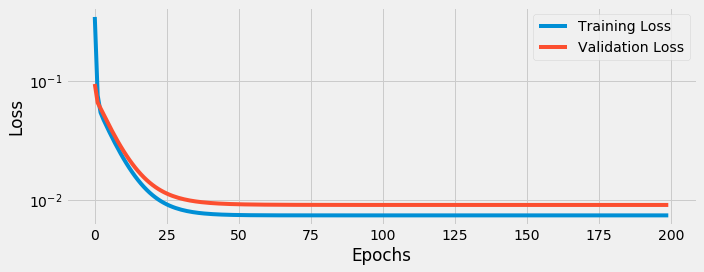

In [44]:
fig = plt.figure(figsize=(10, 4))
plt.plot(losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()

# TensorBoard

## SummaryWriter

In [45]:
writer = SummaryWriter('runs/test')

## add_graph

In [46]:
writer.add_graph(model)

TypeError: 'NoneType' object is not iterable

In [47]:
# Fetching a tuple of feature (sample_x) and label (sample_y)
sample_x, sample_y = next(iter(train_loader))

# Since our model was sent to device, we need to do the same with the data
# Even here, both model and data need to be on the same device!
writer.add_graph(model, sample_x.to(device))

## add_scalars

In [48]:
writer.add_scalars('loss', {'training': loss, 'validation': val_loss}, epoch)

### Model Configuration V3

In [49]:
%run -i data_preparation/v2.py

<Figure size 432x288 with 0 Axes>

In [50]:
%%writefile model_configuration/v3.py

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

# Step 0 - Initializes parameters "a" and "b" randomly
torch.manual_seed(42)
# Now we can create a model and send it at once to the device
model = nn.Sequential(nn.Linear(1, 1)).to(device)

# Defines a SGD optimizer to update the parameters (now retrieved directly from the model)
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

# Creates the train_step function for our model, loss function and optimizer
train_step = make_train_step(model, loss_fn, optimizer)

# Creates the val_step function for our model and loss function
val_step = make_val_step(model, loss_fn)

# Creates a Summary Writer to interface with TensorBoard
writer = SummaryWriter('runs/simple_linear_regression')

# Fetches a single mini-batch so we can use add_graph
x_sample, y_sample = next(iter(train_loader))
writer.add_graph(model, x_sample.to(device))

Writing model_configuration/v3.py


In [51]:
%run -i model_configuration/v3.py

### Model Training V5

In [52]:
%%writefile model_training/v5.py

# Defines number of epochs
n_epochs = 200

losses = []
val_losses = []

for epoch in range(n_epochs):
    # inner loop
    loss = mini_batch(device, train_loader, train_step)
    losses.append(loss)
    
    # VALIDATION
    # no gradients in validation!
    with torch.no_grad():
        val_loss = mini_batch(device, val_loader, val_step)
        val_losses.append(val_loss)
    
    # Records both losses for each epoch under the main tag "loss"
    writer.add_scalars(main_tag='loss',
                       tag_scalar_dict={'training': loss, 'validation': val_loss},
                       global_step=epoch)

# Closes the writer
writer.close()

Overwriting model_training/v5.py


In [53]:
%run -i model_training/v5.py

In [54]:
# Checks model's parameters
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9440]], device='cuda:0')), ('0.bias', tensor([1.0249], device='cuda:0'))])


# Saving and Loading Models

### Cell 2.4

In [55]:
checkpoint = {'epoch': n_epochs,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': losses,
              'val_loss': val_losses}

torch.save(checkpoint, 'model_checkpoint.pth')

### Cell 2.5

In [56]:
checkpoint = torch.load('model_checkpoint.pth')

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

epoch = checkpoint['epoch']
losses = checkpoint['loss']
val_losses = checkpoint['val_loss']

In [57]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9440]], device='cuda:0')), ('0.bias', tensor([1.0249], device='cuda:0'))])


# Putting It All Together

In [58]:
# %load data_preparation/v2.py

torch.manual_seed(13)

# Builds tensors from numpy arrays BEFORE split
x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(y).float()

# Builds dataset containing ALL data points
dataset = TensorDataset(x_tensor, y_tensor)

# Performs the split
train_data, val_data = random_split(dataset, [80, 20])

# Builds a loader of each set
train_loader = DataLoader(dataset=train_data, batch_size=16)
val_loader = DataLoader(dataset=val_data, batch_size=16)

In [59]:
# %load model_configuration/v3.py

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

# Step 0 - Initializes parameters "a" and "b" randomly
torch.manual_seed(42)
# Now we can create a model and send it at once to the device
model = nn.Sequential(nn.Linear(1, 1)).to(device)

# Defines a SGD optimizer to update the parameters (now retrieved directly from the model)
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

# Creates the train_step function for our model, loss function and optimizer
train_step = make_train_step(model, loss_fn, optimizer)

# Creates the val_step function for our model and loss function
val_step = make_val_step(model, loss_fn)

# Creates a Summary Writer to interface with TensorBoard
writer = SummaryWriter('runs/simple_linear_regression')

# Fetches a single mini-batch so we can use add_graph
x_sample, y_sample = next(iter(train_loader))
writer.add_graph(model, x_sample.to(device))

In [60]:
# %load model_training/v5.py

# Defines number of epochs
n_epochs = 200

losses = []
val_losses = []

for epoch in range(n_epochs):
    # inner loop
    loss = mini_batch(device, train_loader, train_step)
    losses.append(loss)
    
    # VALIDATION
    # no gradients in validation!
    with torch.no_grad():
        val_loss = mini_batch(device, val_loader, val_step)
        val_losses.append(val_loss)
    
    # Records both losses for each epoch under the main tag "loss"
    writer.add_scalars(main_tag='loss',
                       tag_scalar_dict={'training': loss, 'validation': val_loss},
                       global_step=epoch)

# Closes the writer
writer.close()

In [61]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9440]], device='cuda:0')), ('0.bias', tensor([1.0249], device='cuda:0'))])
